# Prueba de modelos sin One Hot Encoding

En este Notebook, se procede a probar diferentes modelos que puedan servirnos como base para la creación del modelo o modelos finales que se usarán en la herramienta SNPTool.

Primero, se importarán las librerías y datos necesarios.
Después, se hará un preprocesamiento de los datos, codificando las variables categóricas que sean necesarias, y exportando el dataset para que no tengan que ser reentrenados todos los modelos cada vez que se quiera realizar una modificación en alguno de ellos. 

Posteriormente, exploraremos varios tipos de modelos. Los dos candidatos más posibles para ser buenos tipos de modelos son los Random Forest Classifier y XGBoost, ya que poseen buenas cualidades para el análisis de datos bioestadísticos.

Así mismo, probaremos por un lado modelos con y sin aminoácidos

## Importamos los datasets y las librerías 

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import re
from joblib import dump
from tqdm.notebook import tqdm
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Evitamos que imprima por pantalla los Warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\alejs\OneDrive\Documentos\GitHub\TFG\datasets\model_dataset.csv")

Utilizaremos las columnas: 
    
    -'hg19_chr' (código del cromosoma)
    -'hg19_pos(1-based)' (posición dentro del cromosoma)
    -'ref_code' (código de referencia de la base inicial) 
    -'alt_code' (código de referencia de la base producida)
    -'aaref_code' (código de referencia del aminoácido inicial) 
    -'aaalt_code' (código de referencia del aminoácido producido) 
    
La columna target es la columna 'patho', la cual vale 0 si proviene del dataset benign, y 1 si procede del dataset patho

## Random Forest Classifier con aminoácidos

Matriz de confusión, sin normalizar
[[4239  244]
 [ 289 2186]]
Matriz de confusión normalizada
[[0.94557216 0.05442784]
 [0.11676768 0.88323232]]


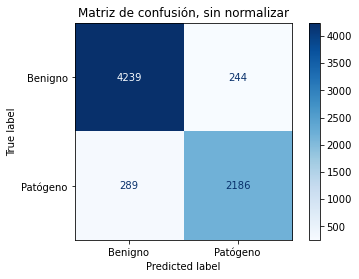

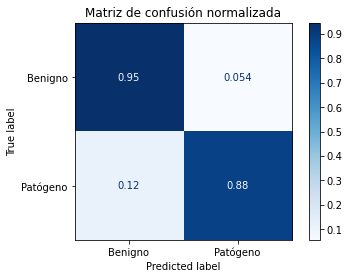

Feature ranking:
1. feature hg19_pos(1-based) (0.516214)
2. feature hg19_chr (0.182256)
3. feature aaalt_code (0.121072)
4. feature aaref_code (0.112061)
5. feature ref_code (0.035157)
6. feature alt_code (0.033240)


In [3]:
cols = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code']

X_1 = df[cols]
y_1 = df[['patho']]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state=0, test_size=0.2)

features_1 = X_1.columns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

clf_1 = RandomForestClassifier(max_depth=None, random_state=0)
clf_1.fit(X_train_1, y_train_1)

y_pred_1 = clf_1.predict(X_test_1)

titles_options = [("Matriz de confusión, sin normalizar", None),
                  ("Matriz de confusión normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_1, X_test_1, y_test_1,
                                 display_labels=['Benigno','Patógeno'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.savefig(fname="imgs/confusion_matrix/model1_"+title)
    print(title)
    print(disp.confusion_matrix)

plt.show()

importances = clf_1.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_1.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
features_1 = X_1.columns

for f in range(0,len(features_1)):
    print("%d. feature %s (%f)" % (f + 1, features_1[indices[f]], importances[indices[f]]))

## Random Forest Classifier sin aminoácidos

Matriz de confusión, sin normalizar
[[1828  342]
 [ 347  729]]
Matriz de confusión normalizada
[[0.84239631 0.15760369]
 [0.32249071 0.67750929]]


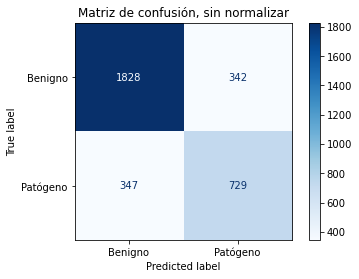

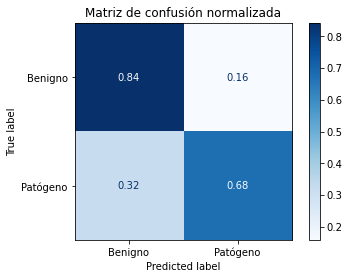

Feature ranking:
1. feature hg19_pos(1-based) (0.824121)
2. feature hg19_chr (0.112130)
3. feature ref_code (0.034645)
4. feature alt_code (0.029104)


In [4]:
columns = ['hg19_chr', 'hg19_pos(1-based)', 'ref_code','alt_code']
tmp = df[[ 'hg19_chr', 'hg19_pos(1-based)', 'ref_code','alt_code','patho']].dropna().drop_duplicates()
X_5 = tmp[columns]
y_5 = tmp[['patho']]

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, random_state=1, test_size=0.2)

features_5 = X_5.columns

clf_5 = RandomForestClassifier(max_depth=200, random_state=0)
clf_5.fit(X_train_5, y_train_5)

y_pred_5 = clf_5.predict(X_test_5)

titles_options = [("Matriz de confusión, sin normalizar", None),
                  ("Matriz de confusión normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_5, X_test_5, y_test_5,
                                 display_labels=['Benigno','Patógeno'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.savefig(fname="imgs/confusion_matrix/model5_"+title)

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

importances = clf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_5.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
features_5 = X_5.columns

for f in range(X_5.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features_5[indices[f]], importances[indices[f]]))

## Random Forest Regressors con los aminoácidos

Score de SIFT_score: 0.6131575289374884


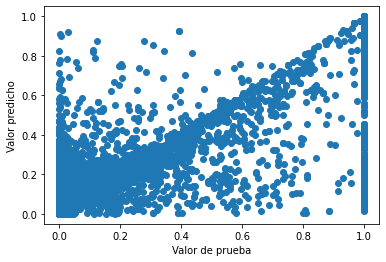

Score de SIFT4G_score: 0.6324140247809836


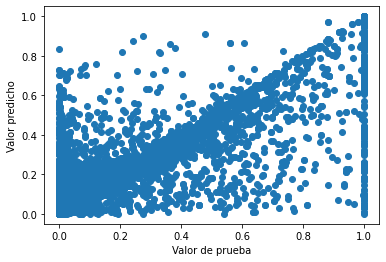

Score de Polyphen2_HDIV_score: 0.6974029505968575


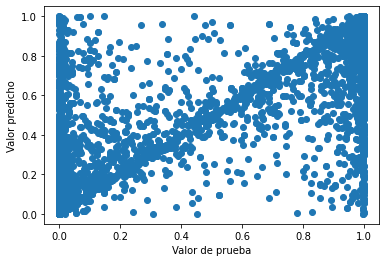

Score de Polyphen2_HVAR_score: 0.6903739243743932


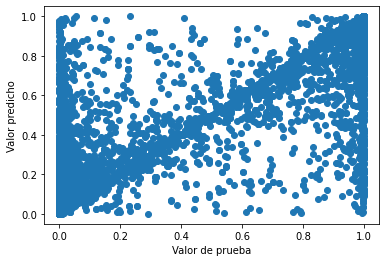

Score de LRT_score: 0.5768060481339796


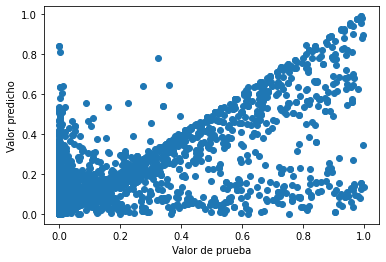

Score de MutationTaster_score: 0.6174362217470861


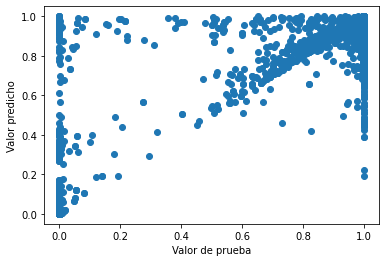

Score de MutationAssessor_score: 0.6774471228275905


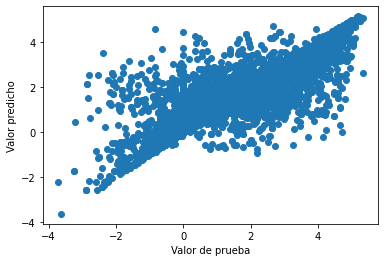

Score de FATHMM_score: 0.8765520288638468


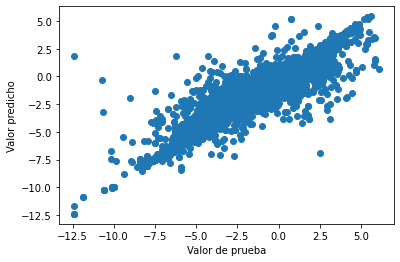

Score de PROVEAN_score: 0.7554538663845051


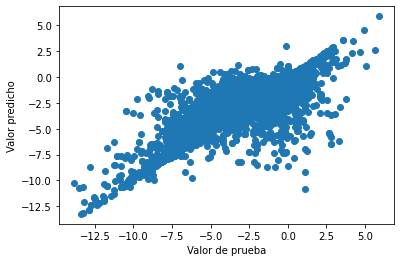

Score de VEST4_score: 0.6951763878023307


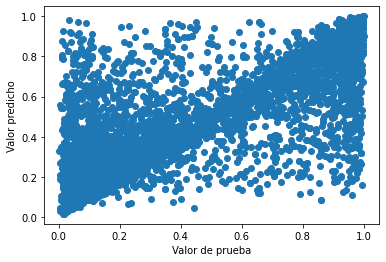

Score de MetaSVM_score: 0.7895385147734639


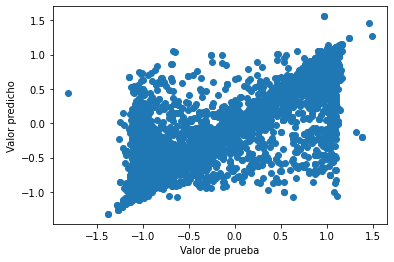

Score de MetaLR_score: 0.8155204068145746


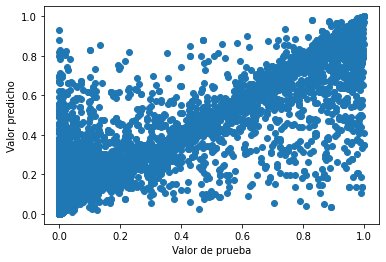

Score de REVEL_score: 0.7739638642144163


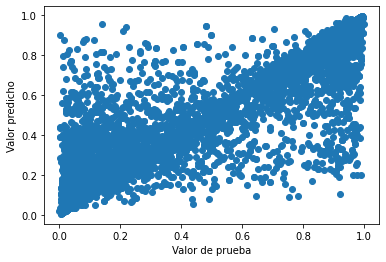

Score de MVP_score: 0.7290392556176923


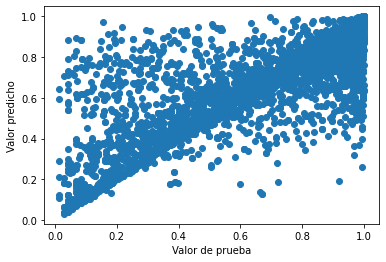

Score de MPC_score: 0.8306378281630203


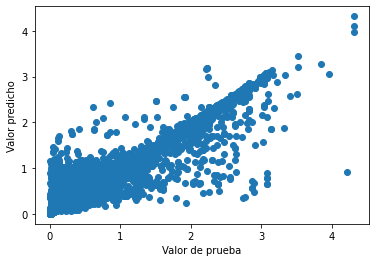

Score de PrimateAI_score: 0.7109002489580248


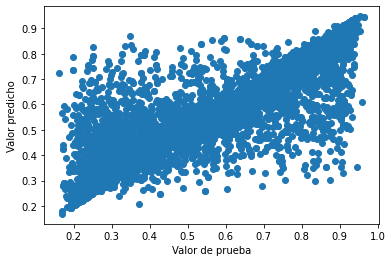

Score de DEOGEN2_score: 0.784706670968201


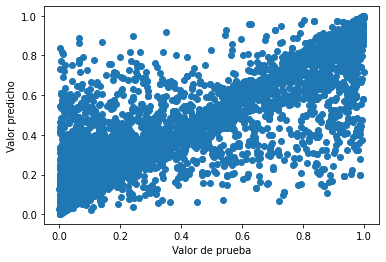

Score de BayesDel_addAF_score: 0.7992851312201517


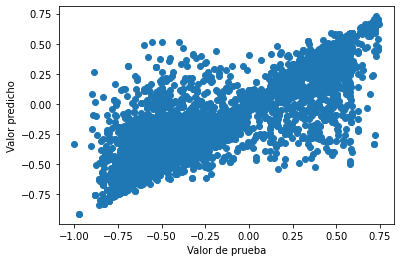

Score de BayesDel_noAF_score: 0.763441494587502


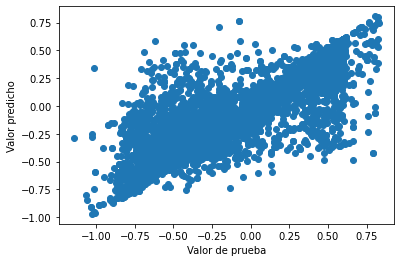

Score de ClinPred_score: 0.7681189482880044


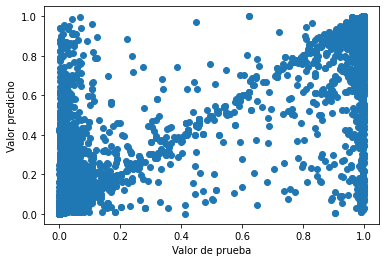

Score de LIST-S2_score: 0.6060590027668369


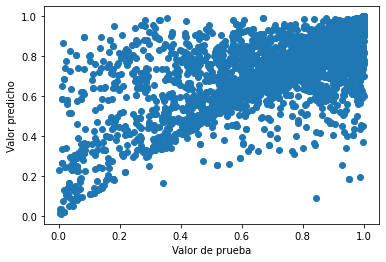

Score de DANN_score: 0.6266591255144907


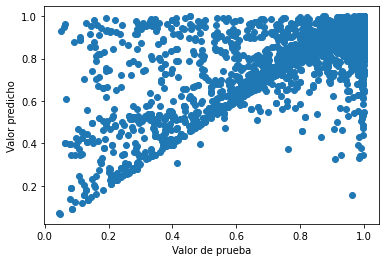

Score de fathmm-MKL_coding_score: 0.6565828350729359


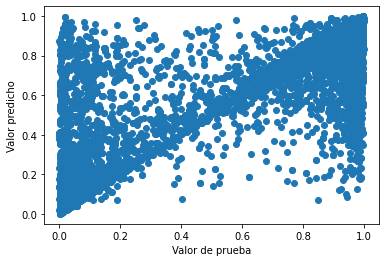

Score de fathmm-XF_coding_score: 0.695213267017874


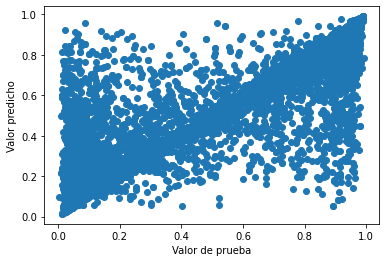

Score de GenoCanyon_score: 0.7298338534788174


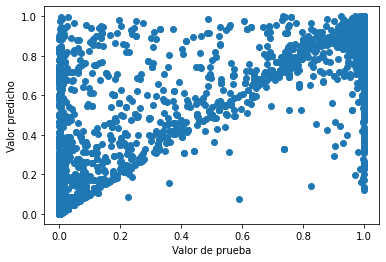

Score de integrated_fitCons_score: 0.7770196582978917


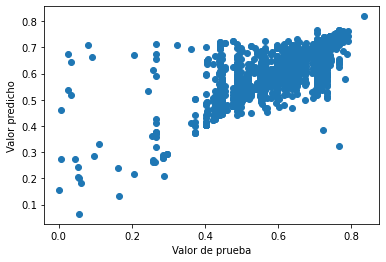

Score de GM12878_fitCons_score: 0.816684155376601


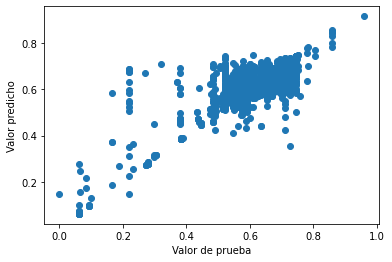

Score de H1-hESC_fitCons_score: 0.7262679357063535


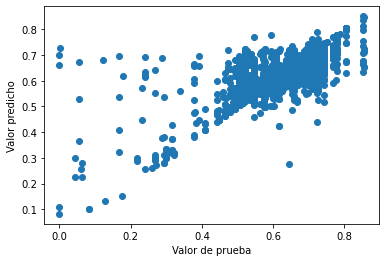

Score de HUVEC_fitCons_score: 0.7841121069442396


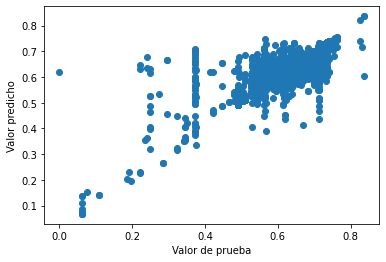

Score de LRT_score_reverted: 0.5699301482158186


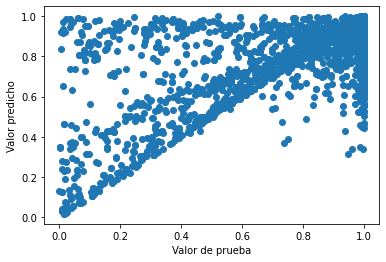

<Figure size 432x288 with 0 Axes>

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

scores = [x for x in df.columns if 'score' in x and 'norm' not in x and 'FLAG' not in x]
models = {}
r2scores = {}

for score in tqdm(scores):
    
    columns = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code',score]
    tmp_df = df[['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code',score]].dropna().sort_values(by=score)
    X_tmp = tmp_df[['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code']]
    y_tmp = tmp_df[[score]]

    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp, y_tmp, random_state=1, test_size=0.2)

    features_tmp = columns
    clf_tmp = RandomForestRegressor(max_depth=200, random_state=0)
    clf_tmp.fit(X_train_tmp, y_train_tmp)

    y_pred_tmp = clf_tmp.predict(X_test_tmp)

    print("Score de " + score + ":",r2_score(y_test_tmp, y_pred_tmp))
    
    plt.scatter(y_test_tmp, y_pred_tmp)
    plt.xlabel('Valor de prueba')
    plt.ylabel('Valor predicho')
    plt.show()    
    plt.savefig(fname="imgs/scatters/without_ohe/"+score)

    models[score] = clf_tmp    
    r2scores[score]=r2_score(y_test_tmp, y_pred_tmp)

¿Cuáles son los modelos que han obtenido un r2_score mayor a 0.75?

In [6]:
print([i for i in r2scores.keys() if r2scores[i] > 0.75])

['FATHMM_score', 'PROVEAN_score', 'MetaSVM_score', 'MetaLR_score', 'REVEL_score', 'MPC_score', 'DEOGEN2_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'ClinPred_score', 'integrated_fitCons_score', 'GM12878_fitCons_score', 'HUVEC_fitCons_score']


In [7]:
print([i for i in r2scores.keys() if r2scores[i] > 0.85])

['FATHMM_score']


## Modelo con las columnas 75% de r2 score

Matriz de confusión, sin normalizar
[[2279   26]
 [  19 1883]]
Matriz de confusión normalizada
[[0.98872017 0.01127983]
 [0.00998948 0.99001052]]


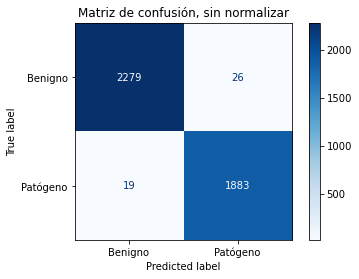

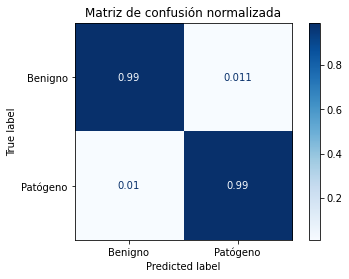

Feature ranking:
1. feature ClinPred_score (0.217363)
2. feature BayesDel_addAF_score (0.152706)
3. feature BayesDel_noAF_score (0.102768)
4. feature VEST4_score (0.093915)
5. feature MetaSVM_score (0.085433)
6. feature REVEL_score (0.063177)
7. feature MVP_score (0.058791)
8. feature DEOGEN2_score (0.050669)
9. feature MetaLR_score (0.023031)
10. feature Polyphen2_HVAR_score (0.022539)
11. feature fathmm-XF_coding_score (0.019240)
12. feature SIFT_score (0.015595)
13. feature SIFT4G_score (0.013619)
14. feature PrimateAI_score (0.009733)
15. feature MutationAssessor_score (0.008150)
16. feature MPC_score (0.007956)
17. feature fathmm-MKL_coding_score (0.006901)
18. feature FATHMM_score (0.004682)
19. feature PROVEAN_score (0.004160)
20. feature hg19_pos(1-based) (0.004139)
21. feature hg19_chr (0.004130)
22. feature MutationTaster_score (0.003899)
23. feature GM12878_fitCons_score (0.003779)
24. feature DANN_score (0.003618)
25. feature Polyphen2_HDIV_score (0.003023)
26. feature H1-h

In [8]:
for_model_4 = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code','patho','SIFT_score', 'SIFT4G_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'PROVEAN_score', 'VEST4_score', 'MetaSVM_score', 'MetaLR_score','REVEL_score', 'MVP_score', 'MPC_score', 'PrimateAI_score', 'DEOGEN2_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'ClinPred_score', 'DANN_score', 'fathmm-MKL_coding_score', 'fathmm-XF_coding_score', 'GenoCanyon_score', 'integrated_fitCons_score', 'GM12878_fitCons_score', 'H1-hESC_fitCons_score', 'HUVEC_fitCons_score']
tmp_df = df[for_model_4].copy().dropna()
if 'patho' in for_model_4:
    for_model_4.remove("patho")
    
X_4 = tmp_df[for_model_4]
y_4 = tmp_df[['patho']]

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, random_state=1, test_size=0.2)

features_4 = X_4.columns

clf_4 = RandomForestClassifier(max_depth=200, random_state=0)
clf_4.fit(X_train_4, y_train_4)

y_pred_4 = clf_4.predict(X_test_4)

titles_options = [("Matriz de confusión, sin normalizar", None),
                  ("Matriz de confusión normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_4, X_test_4, y_test_4,
                                 display_labels=['Benigno','Patógeno'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.savefig(fname="imgs/confusion_matrix/model4_"+title)

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

importances = clf_4.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_4.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
features_4 = X_4.columns

for f in range(0,len(features_4)):
    print("%d. feature %s (%f)" % (f + 1, features_4[indices[f]], importances[indices[f]]))

El modelo parece ser bueno.

## Random Forest Regressor sin los aminoácidos

Score de SIFT_score: 0.5586356312750204


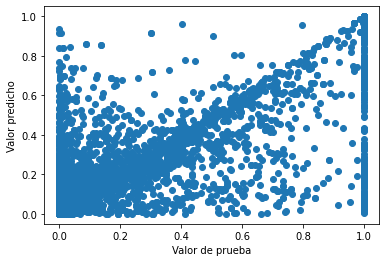

Score de SIFT4G_score: 0.5577084760560445


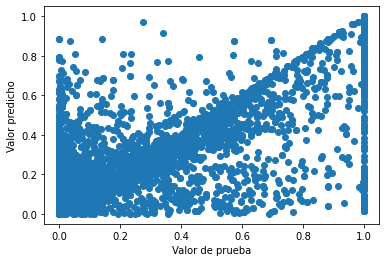

Score de Polyphen2_HDIV_score: 0.6593353216137045


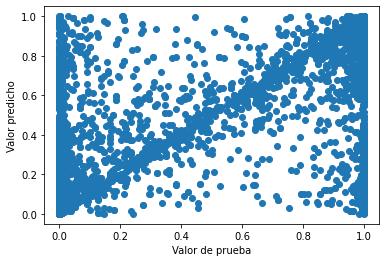

Score de Polyphen2_HVAR_score: 0.6722714965616279


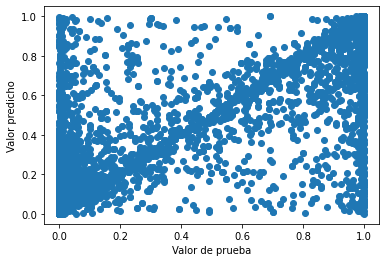

Score de LRT_score: 0.5645079224792154


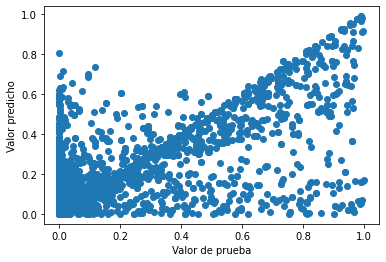

Score de MutationTaster_score: 0.5934709239573223


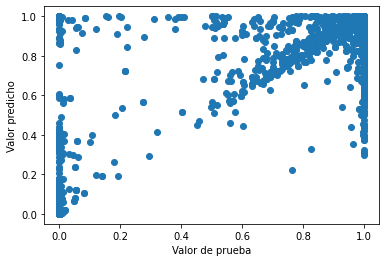

Score de MutationAssessor_score: 0.6923111944119233


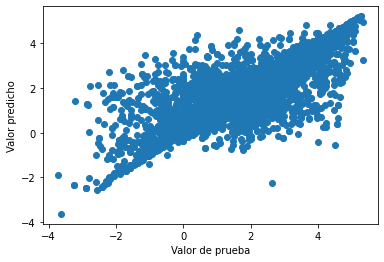

Score de FATHMM_score: 0.8922559553302161


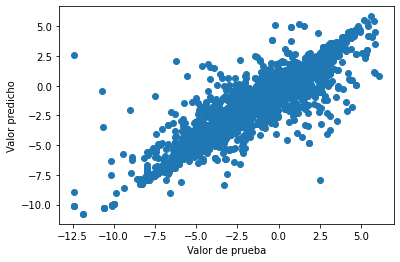

Score de PROVEAN_score: 0.7279741087509668


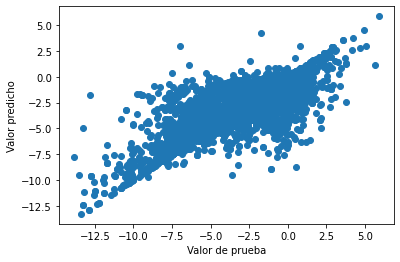

Score de VEST4_score: 0.7628755646648108


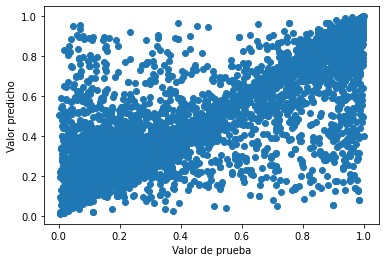

Score de MetaSVM_score: 0.8316337440935464


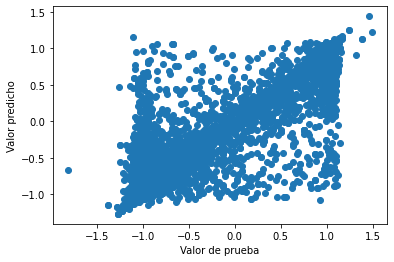

Score de MetaLR_score: 0.8416764377468963


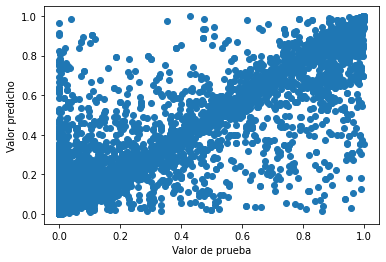

Score de REVEL_score: 0.8374731096068154


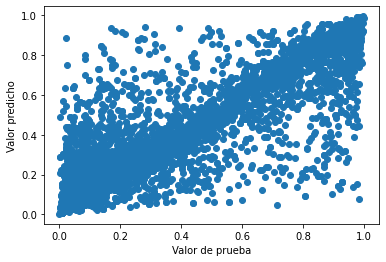

Score de MVP_score: 0.8203756370289882


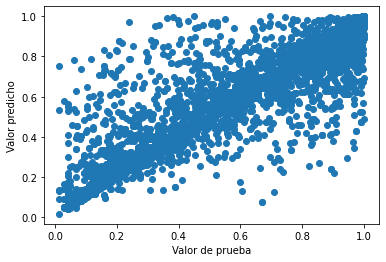

Score de MPC_score: 0.8882855979088279


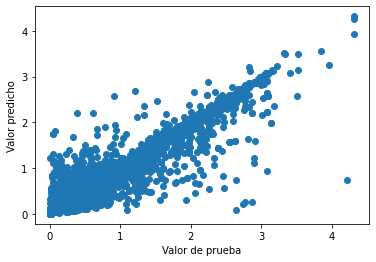

Score de PrimateAI_score: 0.7832235341177922


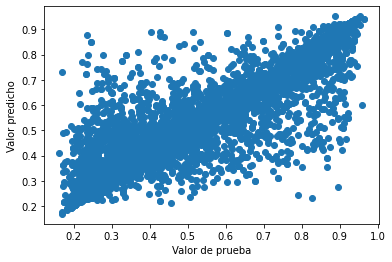

Score de DEOGEN2_score: 0.8539399369050675


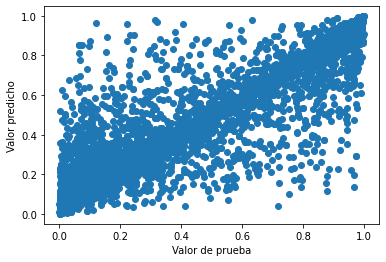

Score de BayesDel_addAF_score: 0.8236405893229157


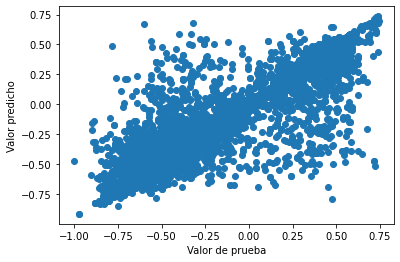

Score de BayesDel_noAF_score: 0.8359421510783518


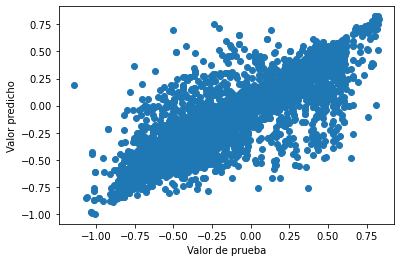

Score de ClinPred_score: 0.8302415039957982


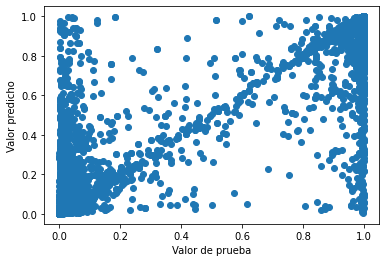

Score de LIST-S2_score: 0.598159726887682


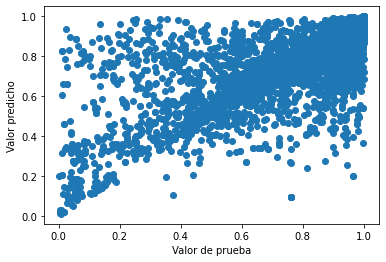

Score de DANN_score: 0.5893941595004555


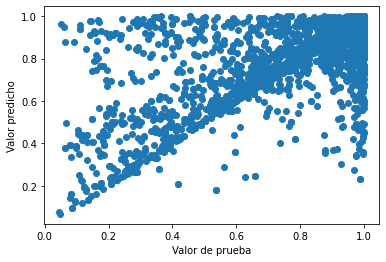

Score de fathmm-MKL_coding_score: 0.6769284073220425


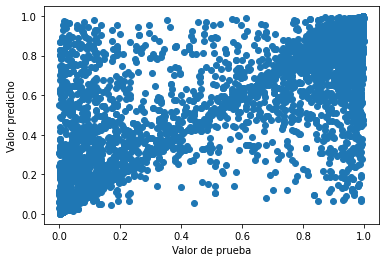

Score de fathmm-XF_coding_score: 0.7617428281095625


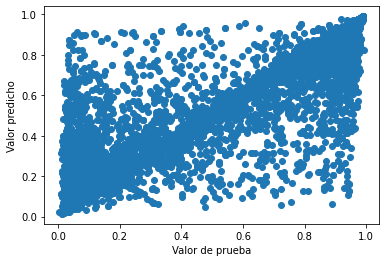

Score de GenoCanyon_score: 0.7473073750601704


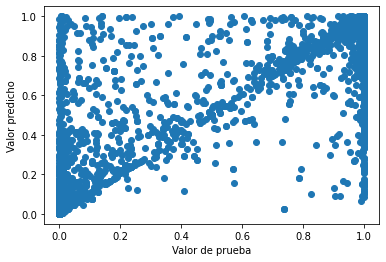

Score de integrated_fitCons_score: 0.7981138069541316


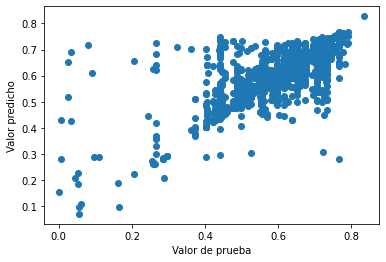

Score de GM12878_fitCons_score: 0.8172530824747599


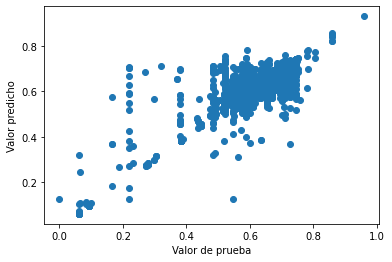

Score de H1-hESC_fitCons_score: 0.741308726602739


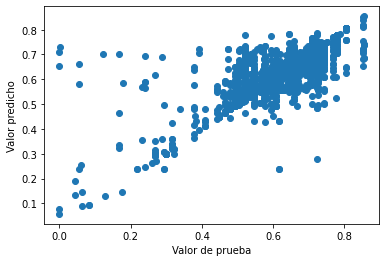

Score de HUVEC_fitCons_score: 0.7954027081254657


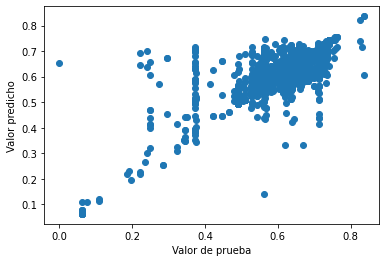

Score de LRT_score_reverted: 0.5551692816087113


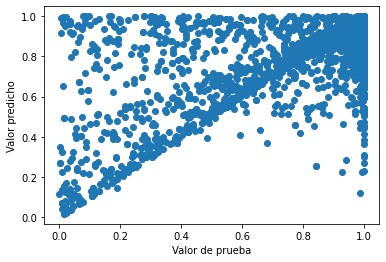

<Figure size 432x288 with 0 Axes>

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

scores_2  = [x for x in df.columns if 'score' in x and 'norm' not in x and 'FLAG' not in x]
models_2 = {}
r2scores_2 = {}

for score in tqdm(scores_2):
    
    columns = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code',score]
    tmp_df = df[['hg19_chr','hg19_pos(1-based)','ref_code','alt_code',score]].dropna().sort_values(by=score)
    X_tmp = tmp_df[['hg19_chr','hg19_pos(1-based)','ref_code','alt_code']]
    y_tmp = tmp_df[[score]]

    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp, y_tmp, random_state=1, test_size=0.2)

    features_tmp = columns
    clf_tmp = RandomForestRegressor(max_depth=200, random_state=0)
    clf_tmp.fit(X_train_tmp, y_train_tmp)

    y_pred_tmp = clf_tmp.predict(X_test_tmp)

    print("Score de " + score + ":",r2_score(y_test_tmp, y_pred_tmp))
    
    plt.scatter(y_test_tmp, y_pred_tmp)
    plt.xlabel('Valor de prueba')
    plt.ylabel('Valor predicho')
    plt.show()    
    plt.savefig(fname="imgs/scatters/without_ohe/"+score)

    models_2[score] = clf_tmp    
    r2scores_2[score]=r2_score(y_test_tmp, y_pred_tmp)

In [13]:
print([i for i in r2scores_2.keys() if r2scores_2[i] > 0.75])

['FATHMM_score', 'VEST4_score', 'MetaSVM_score', 'MetaLR_score', 'REVEL_score', 'MVP_score', 'MPC_score', 'PrimateAI_score', 'DEOGEN2_score', 'BayesDel_addAF_score', 'BayesDel_noAF_score', 'ClinPred_score', 'fathmm-XF_coding_score', 'integrated_fitCons_score', 'GM12878_fitCons_score', 'HUVEC_fitCons_score']


In [14]:
print([i for i in r2scores_2.keys() if r2scores_2[i] > 0.85])

['FATHMM_score', 'MPC_score', 'DEOGEN2_score']


## Utilización de XGBoost como modelo 

In [15]:
import pandas as pd
import xgboost as xgb
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Sin los aminoácidos

In [16]:
tmp = df[['hg19_chr','hg19_pos(1-based)', 'ref_code','alt_code','patho']].dropna().drop_duplicates()

data_train, data_test = train_test_split(tmp, random_state=0, test_size=0.2)

data_train_mat = xgb.DMatrix(data_train.drop("patho", 1), label=data_train["patho"])
data_test_mat = xgb.DMatrix(data_test.drop("patho", 1), label=data_test["patho"])

parametros = {"booster":"gbtree", "max_depth": 4, "eta": 0.3, "objective": "binary:logistic", "nthread":2, "verbosity":0}
rondas = 100

evaluacion = [(data_test_mat, "eval"), (data_train_mat, "train")]

modelo1_xgb = xgb.train(parametros, data_train_mat, rondas, evaluacion)

[0]	eval-logloss:0.65590	train-logloss:0.65630
[1]	eval-logloss:0.63123	train-logloss:0.63059
[2]	eval-logloss:0.61813	train-logloss:0.61763
[3]	eval-logloss:0.60216	train-logloss:0.59904
[4]	eval-logloss:0.59414	train-logloss:0.58838
[5]	eval-logloss:0.58990	train-logloss:0.58194
[6]	eval-logloss:0.58437	train-logloss:0.57690
[7]	eval-logloss:0.57498	train-logloss:0.56727
[8]	eval-logloss:0.57303	train-logloss:0.56379
[9]	eval-logloss:0.56871	train-logloss:0.55792
[10]	eval-logloss:0.56835	train-logloss:0.55624
[11]	eval-logloss:0.56332	train-logloss:0.55171
[12]	eval-logloss:0.56157	train-logloss:0.54922
[13]	eval-logloss:0.55991	train-logloss:0.54622
[14]	eval-logloss:0.55777	train-logloss:0.54301
[15]	eval-logloss:0.55612	train-logloss:0.54130
[16]	eval-logloss:0.55243	train-logloss:0.53661
[17]	eval-logloss:0.54945	train-logloss:0.53321
[18]	eval-logloss:0.54948	train-logloss:0.53244
[19]	eval-logloss:0.54692	train-logloss:0.52956
[20]	eval-logloss:0.54643	train-logloss:0.52811
[2

[[0.93031841 0.13994439]
 [0.23211814 0.53382762]]
0.7985212569316081
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2167
           1       0.79      0.53      0.64      1079

    accuracy                           0.80      3246
   macro avg       0.80      0.73      0.75      3246
weighted avg       0.80      0.80      0.79      3246



[None, None, None]

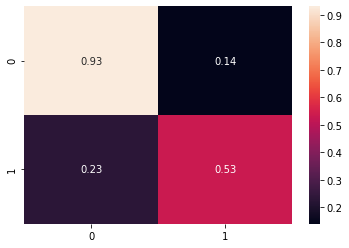

In [17]:
prediccion1 = modelo1_xgb.predict(data_test_mat)
prediccion1 = [1 if i > 0.5 else 0 for i in prediccion1]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)  
    matriz_conf = matriz_conf / matriz_conf.astype(np.float).sum(axis=1)
    sns.heatmap(matriz_conf, annot=True)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metricas1 = metricas(data_test["patho"], prediccion1)
[print(i) for i in metricas1]

#### Cambiando los parámetros de profundidad y rondas

In [18]:
tmp = df[['hg19_chr','hg19_pos(1-based)', 'ref_code','alt_code','patho']].dropna().drop_duplicates()

data_train, data_test = train_test_split(tmp, random_state=0, test_size=0.3)

data_train_mat = xgb.DMatrix(data_train.drop("patho", 1), label=data_train["patho"])
data_test_mat = xgb.DMatrix(data_test.drop("patho", 1), label=data_test["patho"])

parametros = {"booster":"gbtree", "max_depth": 8, "eta": 0.3, "nthread":2}
rondas = 200

evaluacion = [(data_test_mat, "eval"), (data_train_mat, "train")]

modelo2_xgb = xgb.train(parametros, data_train_mat, rondas, evaluacion)

[0]	eval-rmse:0.47353	train-rmse:0.46936
[1]	eval-rmse:0.44616	train-rmse:0.43554
[2]	eval-rmse:0.42879	train-rmse:0.41351
[3]	eval-rmse:0.42171	train-rmse:0.40144
[4]	eval-rmse:0.41356	train-rmse:0.38967
[5]	eval-rmse:0.41031	train-rmse:0.38224
[6]	eval-rmse:0.40868	train-rmse:0.37893
[7]	eval-rmse:0.40673	train-rmse:0.37424
[8]	eval-rmse:0.39963	train-rmse:0.36467
[9]	eval-rmse:0.39705	train-rmse:0.36038
[10]	eval-rmse:0.39468	train-rmse:0.35673
[11]	eval-rmse:0.39314	train-rmse:0.35191
[12]	eval-rmse:0.39137	train-rmse:0.34863
[13]	eval-rmse:0.39094	train-rmse:0.34682
[14]	eval-rmse:0.38655	train-rmse:0.33828
[15]	eval-rmse:0.38404	train-rmse:0.33324
[16]	eval-rmse:0.38135	train-rmse:0.32819
[17]	eval-rmse:0.38022	train-rmse:0.32530
[18]	eval-rmse:0.37982	train-rmse:0.32420
[19]	eval-rmse:0.37800	train-rmse:0.32040
[20]	eval-rmse:0.37302	train-rmse:0.31244
[21]	eval-rmse:0.37074	train-rmse:0.30759
[22]	eval-rmse:0.37074	train-rmse:0.30720
[23]	eval-rmse:0.37021	train-rmse:0.30605
[2

[194]	eval-rmse:0.35072	train-rmse:0.15607
[195]	eval-rmse:0.35078	train-rmse:0.15604
[196]	eval-rmse:0.35082	train-rmse:0.15588
[197]	eval-rmse:0.35125	train-rmse:0.15494
[198]	eval-rmse:0.35124	train-rmse:0.15466
[199]	eval-rmse:0.35133	train-rmse:0.15401


[[0.9375     0.12339646]
 [0.17883663 0.64691509]]
0.8398028342575478
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      3232
           1       0.84      0.65      0.73      1637

    accuracy                           0.84      4869
   macro avg       0.84      0.79      0.81      4869
weighted avg       0.84      0.84      0.83      4869



[None, None, None]

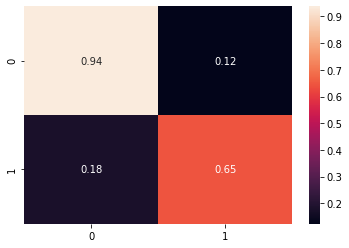

In [19]:
prediccion2 = modelo2_xgb.predict(data_test_mat)
prediccion2 = [1 if i > 0.7 else 0 for i in prediccion2]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    matriz_conf = matriz_conf / matriz_conf.astype(np.float).sum(axis=1)
    sns.heatmap(matriz_conf, annot=True)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metricas2 = metricas(data_test["patho"], prediccion2)
[print(i) for i in metricas2]

### Con los aminoácidos

In [20]:
tmp = df[['hg19_chr','hg19_pos(1-based)', 'ref_code','alt_code','aaref_code','aaalt_code','patho']].dropna().drop_duplicates()

data_train, data_test = train_test_split(tmp, random_state=0, test_size=0.3)

data_train_mat = xgb.DMatrix(data_train.drop("patho", 1), label=data_train["patho"])
data_test_mat = xgb.DMatrix(data_test.drop("patho", 1), label=data_test["patho"])

parametros = {"booster":"gbtree", "max_depth": 10, "eta": 0.3, "nthread":2}
rondas = 100

evaluacion = [(data_test_mat, "eval"), (data_train_mat, "train")]

modelo3_xgb = xgb.train(parametros, data_train_mat, rondas, evaluacion)

[0]	eval-rmse:0.46570	train-rmse:0.45320
[1]	eval-rmse:0.44764	train-rmse:0.42486
[2]	eval-rmse:0.43747	train-rmse:0.40924
[3]	eval-rmse:0.41599	train-rmse:0.37984
[4]	eval-rmse:0.41181	train-rmse:0.36661
[5]	eval-rmse:0.40789	train-rmse:0.35798
[6]	eval-rmse:0.40115	train-rmse:0.34460
[7]	eval-rmse:0.39038	train-rmse:0.32621
[8]	eval-rmse:0.38757	train-rmse:0.31890
[9]	eval-rmse:0.38382	train-rmse:0.30855
[10]	eval-rmse:0.38255	train-rmse:0.29923
[11]	eval-rmse:0.38042	train-rmse:0.29361
[12]	eval-rmse:0.37982	train-rmse:0.29020
[13]	eval-rmse:0.37673	train-rmse:0.28170
[14]	eval-rmse:0.37510	train-rmse:0.27704
[15]	eval-rmse:0.37509	train-rmse:0.27561
[16]	eval-rmse:0.37387	train-rmse:0.27265
[17]	eval-rmse:0.37180	train-rmse:0.26804
[18]	eval-rmse:0.37185	train-rmse:0.26702
[19]	eval-rmse:0.36909	train-rmse:0.26109
[20]	eval-rmse:0.36707	train-rmse:0.25624
[21]	eval-rmse:0.36684	train-rmse:0.25346
[22]	eval-rmse:0.36700	train-rmse:0.24690
[23]	eval-rmse:0.36634	train-rmse:0.24446
[2

[[0.95300983 0.09261501]
 [0.22880835 0.54903148]]
0.8170334148329258
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      3256
           1       0.86      0.55      0.67      1652

    accuracy                           0.82      4908
   macro avg       0.83      0.75      0.77      4908
weighted avg       0.82      0.82      0.80      4908



[None, None, None]

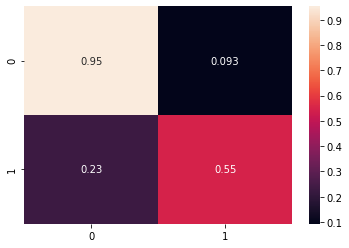

In [21]:
prediccion3 = modelo3_xgb.predict(data_test_mat)
prediccion3 = [1 if i > 0.7 else 0 for i in prediccion3]

def metricas(objetivo, prediccion):
    matriz_conf = confusion_matrix(objetivo, prediccion)
    matriz_conf = matriz_conf / matriz_conf.astype(np.float).sum(axis=1)
    sns.heatmap(matriz_conf, annot=True)
    score = accuracy_score(objetivo, prediccion)
    reporte = classification_report(objetivo, prediccion)
    metricas = [matriz_conf, score, reporte]
    return(metricas)

metricas3 = metricas(data_test["patho"], prediccion3)
[print(i) for i in metricas3]

Los resultados son peores respecto al resto de modelos basados en Random Forest.

#### Check: importación de librerías y Dataset 

In [22]:
import pandas as pd
import xgboost as xgb
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\alejs\OneDrive\Documentos\GitHub\TFG\datasets\model_dataset.csv")

# Modelos utilizando Bayes, ClinPred, Fathmm, Provean

Podemos usar los scores predichos por los modelos anteriores para ClinPred, Bayes, FATHMM y PROVEAN como input para dos modelos: uno con y otro sin los aminoácidos.

## Con los aminoácidos

Matriz de confusión, sin normalizar
[[4415   38]
 [  31 2274]]
Matriz de confusión normalizada
[[0.99146643 0.00853357]
 [0.01344902 0.98655098]]


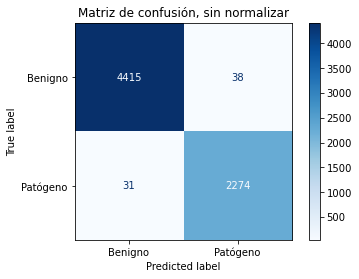

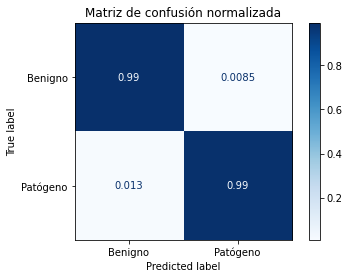

Ranking de características:
1. columna ClinPred_score (0.388464)
2. columna BayesDel_addAF_score (0.271256)
3. columna BayesDel_noAF_score (0.160673)
4. columna PROVEAN_score (0.086013)
5. columna FATHMM_score (0.048433)
6. columna hg19_pos(1-based) (0.016948)
7. columna hg19_chr (0.010446)
8. columna aaalt_code (0.006759)
9. columna aaref_code (0.005482)
10. columna ref_code (0.002843)
11. columna alt_code (0.002682)


In [23]:
for_model_7 = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','aaref_code','aaalt_code','ClinPred_score','BayesDel_addAF_score','BayesDel_noAF_score','FATHMM_score','PROVEAN_score','patho']

tmp_df = df[for_model_7].copy().dropna()
if 'patho' in for_model_7:
    for_model_7.remove("patho")
    
X_7 = tmp_df[for_model_7]
y_7 = tmp_df[['patho']]

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, random_state=1, test_size=0.2)

features_7 = X_7.columns

clf_7 = RandomForestClassifier(max_depth=200, random_state=0)
clf_7.fit(X_train_7, y_train_7)

y_pred_7 = clf_7.predict(X_test_7)

titles_options = [("Matriz de confusión, sin normalizar", None),
                  ("Matriz de confusión normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_7, X_test_7, y_test_7,
                                 display_labels=['Benigno','Patógeno'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.savefig(fname="imgs/confusion_matrix/model7_"+title)

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

importances_7 = clf_7.feature_importances_
indices_7 = np.argsort(importances_7)[::-1]

# Print the feature ranking
print("Ranking de características:")

for f in range(len(indices_7)):
    print("%d. columna %s (%f)" % (f + 1, features_7[indices_7[f]], importances_7[indices_7[f]]))

El modelo tiene unos resultados muy buenos, por lo que intentaremos replicarlo para utilizarlo sin los aminoácidos.

## Sin los aminoácidos

Matriz de confusión, sin normalizar
[[4416   37]
 [  32 2273]]
Matriz de confusión normalizada
[[0.99169099 0.00830901]
 [0.01388286 0.98611714]]


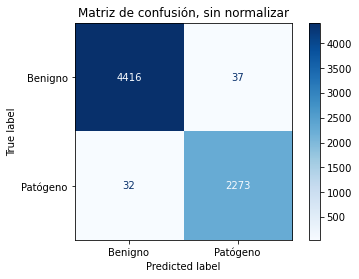

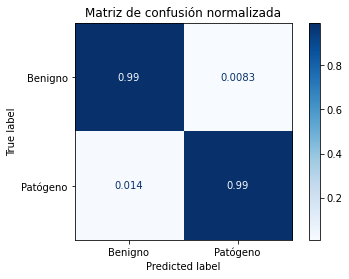

In [24]:
for_model_8 = ['hg19_chr','hg19_pos(1-based)','ref_code','alt_code','ClinPred_score','BayesDel_addAF_score','BayesDel_noAF_score','FATHMM_score','PROVEAN_score','patho']

tmp_df = df[for_model_8].copy().dropna()
if 'patho' in for_model_8:
    for_model_8.remove("patho")
    
X_8 = tmp_df[for_model_8]
y_8 = tmp_df[['patho']]

X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_8, y_8, random_state=1, test_size=0.2)

features_8 = X_8.columns

clf_8 = RandomForestClassifier(max_depth=200, random_state=0)
clf_8.fit(X_train_8, y_train_8)

y_pred_8 = clf_8.predict(X_test_8)

titles_options = [("Matriz de confusión, sin normalizar", None),
                  ("Matriz de confusión normalizada", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf_8, X_test_8, y_test_8,
                                 display_labels=['Benigno','Patógeno'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    plt.savefig(fname="imgs/confusion_matrix/model8_"+title)

    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Teniendo en cuenta de que ambos modelos actúan igual, es mejor no utilizar los aminoácidos, ya que son variables que no deben de aportar nada.

Exactamente los mismos resultados que el anterior. Por tanto, puede ser una buena idea utilizar estos dos modelos como modelos finales. Vamos a medir en qué valores se producen el mayor error.

### Rog Curves

In [25]:
from sklearn.metrics import f1_score

print(f1_score(y_test_7, y_pred_7, average='binary'))
print(f1_score(y_test_8, y_pred_8, average='binary'))

0.9850552306692657
0.9850487540628386


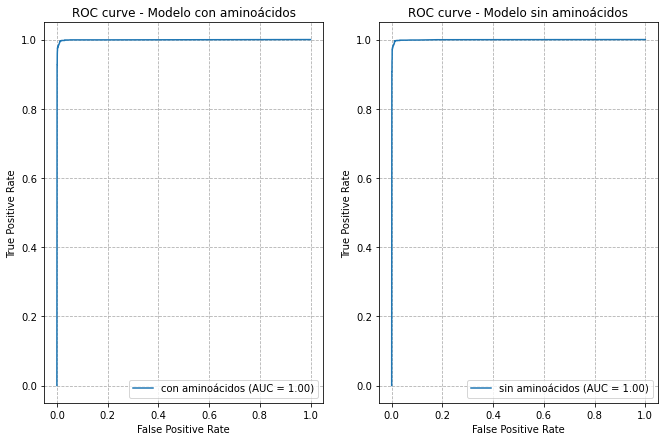

In [26]:
from sklearn.metrics import plot_roc_curve

fig, [ax_roc1, ax_roc2] = plt.subplots(1, 2, figsize=(11, 7))

plot_roc_curve(clf_7, X_test_7, y_test_7, ax=ax_roc1, name="con aminoácidos")
plot_roc_curve(clf_8, X_test_8, y_test_8, ax=ax_roc2, name="sin aminoácidos")

ax_roc1.grid(linestyle='--')
ax_roc2.grid(linestyle='--')

ax_roc1.set_title('ROC curve - Modelo con aminoácidos')
ax_roc2.set_title('ROC curve - Modelo sin aminoácidos')

plt.savefig(fname="imgs/confusion_matrix/models_roc_curve")

plt.legend()
plt.show()